# Functions

Import the relevant modules. The structure of this notebook is as follows. 

First I write the relevant functions. 

Then I test the independence test of HSIC is working properly

Then I test the conditional independence test on linear functions with rho both zero and non-zero

Then I test the conditional independence test on non-linear functions with rho both zero and non-zero

Finally I create ensemble-averaging RESIT test on both linear and non-linear functions with rho zero and non-zero

In [117]:
from CCIT import CCIT
from CCIT import DataGen
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
scaler_Z = StandardScaler()
X = 3*np.random.normal(0,1,50)
X = X.reshape(X.shape[0],1)
X = scaler_X.fit_transform(X)
Y = 2*np.random.normal(0,1,50)
Y = Y.reshape(Y.shape[0],1)
Y = scaler_Y.fit_transform(Y)
Z = 5*np.random.normal(0,1,50)
Z = Z.reshape(Z.shape[0],1)
Z = scaler_Z.fit_transform(Z)
pvalue = CCIT.CCIT(X,Y,Z,max_depths=[11,15,20],num_iter=30,bootstrap=True)
print(pvalue)

7.749430526330435e-14


In [25]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import datasets
from numpy import shape, fill_diagonal, zeros, mean, sqrt,identity,dot,diag
from numpy.random import permutation, randn
from scipy.spatial.distance import squareform, pdist
from numpy import exp, shape, reshape, sqrt, median
from itertools import combinations, permutations
import networkx as nx
from numpy.random import multivariate_normal
from numpy.random import multivariate_normal
from pygam import GAM, s, f, te

In [27]:
boston = datasets.load_boston()
features = boston.data
features = pd.DataFrame(features)
features = features.drop(columns=[3])
features = np.array(features)
features = pd.DataFrame(features)
features = features.rename({0:'CRIM',1:"ZN",2:"INDUS",3:"NOX",4:"RM",5:"AGE",6:"DIS",7:"RAD",8:"TAX",9:"PTRATIO",10:"B",11:"LSTAT",12:"MEDV"},axis=1)
print(features)

        CRIM    ZN  INDUS    NOX     RM   AGE     DIS  RAD    TAX  PTRATIO  \
0    0.00632  18.0   2.31  0.538  6.575  65.2  4.0900  1.0  296.0     15.3   
1    0.02731   0.0   7.07  0.469  6.421  78.9  4.9671  2.0  242.0     17.8   
2    0.02729   0.0   7.07  0.469  7.185  61.1  4.9671  2.0  242.0     17.8   
3    0.03237   0.0   2.18  0.458  6.998  45.8  6.0622  3.0  222.0     18.7   
4    0.06905   0.0   2.18  0.458  7.147  54.2  6.0622  3.0  222.0     18.7   
..       ...   ...    ...    ...    ...   ...     ...  ...    ...      ...   
501  0.06263   0.0  11.93  0.573  6.593  69.1  2.4786  1.0  273.0     21.0   
502  0.04527   0.0  11.93  0.573  6.120  76.7  2.2875  1.0  273.0     21.0   
503  0.06076   0.0  11.93  0.573  6.976  91.0  2.1675  1.0  273.0     21.0   
504  0.10959   0.0  11.93  0.573  6.794  89.3  2.3889  1.0  273.0     21.0   
505  0.04741   0.0  11.93  0.573  6.030  80.8  2.5050  1.0  273.0     21.0   

          B  LSTAT  
0    396.90   4.98  
1    396.90   9.14  


In [25]:
def indep(data_matrix,i,j):
    data_matrix = np.array(data_matrix)
    X = data_matrix[:,i]
    X = X.reshape(X.shape[0],1)
    Y = data_matrix[:,j]
    Y = Y.reshape(Y.shape[0],1)


    def get_sigma(X):
        n=shape(X)[0]
        if n>1000:
            X=X[permutation(n)[:1000],:]
        dists=squareform(pdist(X, 'euclidean'))
        median_dist=median(dists[dists>0])
        sigma=median_dist/sqrt(2.)
        return sigma
    
    def kernel(X,sigma):
        sq_dists = squareform(pdist(X, 'sqeuclidean'))
        K = exp(-0.5 * (sq_dists) / sigma ** 2)

        return K


    sigmax = get_sigma(X)
    sigmay = get_sigma(Y)
    Kx=kernel(X,sigmax)
    Ky=kernel(Y,sigmay)

    def U_statistic(Kx,Ky):
        m = shape(Kx)[0]
        fill_diagonal(Kx,0.)
        fill_diagonal(Ky,0.)
        K = np.dot(Kx,Ky)
        first_term = np.trace(K)/float(m*(m-3.))
        second_term = np.sum(Kx)*np.sum(Ky)/float(m*(m-3.)*(m-1.)*(m-2.))
        third_term = 2.*np.sum(K)/float(m*(m-3.)*(m-2.))
        return first_term+second_term-third_term
    
    num_shuffles=1000
    ny=shape(Y)[0]
    test_statistic = U_statistic(Kx,Ky)
    null_samples=zeros(num_shuffles)
    for jj in range(num_shuffles):
        pp = permutation(ny)
        Kpp = Ky[pp,:][:,pp]
        null_samples[jj]=U_statistic(Kx,Kpp)

    pvalue = ( 1 + sum( null_samples > test_statistic ) ) / float( 1 + 1000)
  
    return pvalue, test_statistic

In [26]:
def cond_indep(data_matrix,i,j,k):
    data_matrix=np.array(data_matrix)
    X = data_matrix[:,i]
    Y = data_matrix[:,j]
    k = list(k)
    Z = data_matrix[:,k]

    GPR_1 = GaussianProcessRegressor()
    GPR_1.fit(np.array(Z),np.array(X))
    predictions_gpr_1 = GPR_1.predict(np.array(Z))
    res_gpr_1 = predictions_gpr_1 - np.array(X)

    GPR_2 = GaussianProcessRegressor()
    GPR_2.fit(np.array(Z),np.array(Y))
    predictions_gpr_2 = GPR_2.predict(np.array(Z))
    res_gpr_2 = predictions_gpr_2 - np.array(Y)
    
    res_x = res_gpr_1.reshape(res_gpr_1.shape[0],1)
    res_y = res_gpr_2.reshape(res_gpr_2.shape[0],1)

    def get_sigma(X):
        n=shape(X)[0]
        if n>1000:
            X=X[permutation(n)[:1000],:]
        dists=squareform(pdist(X, 'euclidean'))
        median_dist=median(dists[dists>0])
        sigma=median_dist/sqrt(2.)
        return sigma
    
    def kernel(X,sigma):
        sq_dists = squareform(pdist(X, 'sqeuclidean'))
        K = exp(-0.5 * (sq_dists) / sigma ** 2)

        return K


    sigmax = get_sigma(res_x)
    sigmay = get_sigma(res_y)
    Kx=kernel(res_x,sigmax)
    Ky=kernel(res_y,sigmay)

    def U_statistic(Kx,Ky):
        m = shape(Kx)[0]
        fill_diagonal(Kx,0.)
        fill_diagonal(Ky,0.)
        K = np.dot(Kx,Ky)
        first_term = np.trace(K)/float(m*(m-3.))
        second_term = np.sum(Kx)*np.sum(Ky)/float(m*(m-3.)*(m-1.)*(m-2.))
        third_term = 2.*np.sum(K)/float(m*(m-3.)*(m-2.))
        return first_term+second_term-third_term
    
    num_shuffles=1000
    ny=shape(res_y)[0]
    test_statistic = U_statistic(Kx,Ky)
    null_samples=zeros(num_shuffles)
    for jj in range(num_shuffles):
        pp = permutation(ny)
        Kpp = Ky[pp,:][:,pp]
        null_samples[jj]=U_statistic(Kx,Kpp)

    pvalue = ( 1 + sum( null_samples > test_statistic ) ) / float( 1 + 1000)
  
    return pvalue, res_gpr_1, res_gpr_2, test_statistic

In [6]:
def cond_indep_ensemble(data_matrix,i,j,k):
    X = data_matrix[:,i]
    Y = data_matrix[:,j]
    k = list(k)
    Z = data_matrix[:,k]

    GPR_1 = GaussianProcessRegressor()
    GPR_1.fit(np.array(Z),np.array(X))
    predictions_gpr_1 = GPR_1.predict(np.array(Z).reshape(np.shape(Z)[0],1))
    res_gpr_1 = predictions_gpr_1 - np.array(X)

    GPR_2 = GaussianProcessRegressor()
    GPR_2.fit(np.array(Z),np.array(Y))
    predictions_gpr_2 = GPR_2.predict(np.array(Z).reshape(np.shape(Z)[0],1))
    res_gpr_2 = predictions_gpr_2 - np.array(Y)
    
    """
    MLP_1 = MLPRegressor(hidden_layer_sizes=(5,5),shuffle=True,max_iter=500,alpha=0.1)
    MLP_1.fit(np.array(Z),np.array(X))
    predictions_mlp_1 = MLP_1.predict(np.array(Z).reshape(np.shape(Z)[0],1))
    res_mlp_1 = predictions_mlp_1 - np.array(X).reshape(np.shape(X)[0])
    
    MLP_2 = MLPRegressor(hidden_layer_sizes=(5,5),shuffle=True,max_iter=500,alpha=0.1)
    MLP_2.fit(np.array(Z),np.array(Y))
    predictions_mlp_2 = MLP_2.predict(np.array(Z).reshape(np.shape(Z)[0],1))
    res_mlp_2 = predictions_mlp_2 - np.array(Y).reshape(np.shape(Y)[0])
    """
    GAM_1 = GAM(n_splines=15).fit(np.array(Z),np.array(X))
    predictions_gam_1 = GAM_1.predict(np.array(Z))
    res_gam_1 = predictions_gam_1 - np.array(X).reshape(np.shape(X)[0])
    
    GAM_2 = GAM(n_splines=15).fit(np.array(Z),np.array(Y))
    predictions_gam_2 = GAM_2.predict(np.array(Z))
    res_gam_2 = predictions_gam_2 - np.array(Y).reshape(np.shape(Y)[0])
    
    GAM_3 = GAM(n_splines=20).fit(np.array(Z),np.array(X))
    predictions_gam_3 = GAM_3.predict(np.array(Z))
    res_gam_3 = predictions_gam_3 - np.array(X).reshape(np.shape(X)[0])
    
    GAM_4 = GAM(n_splines=20).fit(np.array(Z),np.array(Y))
    predictions_gam_4 = GAM_4.predict(np.array(Z))
    res_gam_4 = predictions_gam_4 - np.array(Y).reshape(np.shape(Y)[0])
    
    GAM_5 = GAM(n_splines=50).fit(np.array(Z),np.array(X))
    predictions_gam_5 = GAM_5.predict(np.array(Z))
    res_gam_5 = predictions_gam_5 - np.array(X).reshape(np.shape(X)[0])
    
    GAM_6 = GAM(n_splines=50).fit(np.array(Z),np.array(Y))
    predictions_gam_6 = GAM_6.predict(np.array(Z))
    res_gam_6 = predictions_gam_6 - np.array(Y).reshape(np.shape(Y)[0])
    
    res_x = (1/4)*(res_gpr_1.reshape(res_gpr_1.shape[0],1) + res_gam_1.reshape(res_gam_1.shape[0],1) + res_gam_3.reshape(res_gam_3.shape[0],1)+res_gam_5.reshape(res_gam_5.shape[0],1))
    res_y = (1/4)*(res_gpr_2.reshape(res_gpr_2.shape[0],1) +res_gam_2.reshape(res_gam_2.shape[0],1) + res_gam_4.reshape(res_gam_4.shape[0],1) + res_gam_6.reshape(res_gam_6.shape[0],1))

    def get_sigma(X):
        n=shape(X)[0]
        if n>1000:
            X=X[permutation(n)[:1000],:]
        dists=squareform(pdist(X, 'euclidean'))
        median_dist=median(dists[dists>0])
        sigma=median_dist/sqrt(2.)
        return sigma
    
    def kernel(X,sigma):
        sq_dists = squareform(pdist(X, 'sqeuclidean'))
        K = exp(-0.5 * (sq_dists) / sigma ** 2)

        return K


    sigmax = get_sigma(res_x)
    sigmay = get_sigma(res_y)
    Kx=kernel(res_x,sigmax)
    Ky=kernel(res_y,sigmay)

    def U_statistic(Kx,Ky):
        m = shape(Kx)[0]
        fill_diagonal(Kx,0.)
        fill_diagonal(Ky,0.)
        K = np.dot(Kx,Ky)
        first_term = np.trace(K)/float(m*(m-3.))
        second_term = np.sum(Kx)*np.sum(Ky)/float(m*(m-3.)*(m-1.)*(m-2.))
        third_term = 2.*np.sum(K)/float(m*(m-3.)*(m-2.))
        return first_term+second_term-third_term
    
    num_shuffles=1000
    ny=shape(res_y)[0]
    test_statistic = U_statistic(Kx,Ky)
    null_samples=zeros(num_shuffles)
    for jj in range(num_shuffles):
        pp = permutation(ny)
        Kpp = Ky[pp,:][:,pp]
        null_samples[jj]=U_statistic(Kx,Kpp)

    pvalue = ( 1 + sum( null_samples > test_statistic ) ) / float( 1 + 1000)
  
    return pvalue, res_x, res_y, test_statistic

In [7]:
def _create_complete_graph(node_ids):
    """Create a complete graph from the list of node ids.
    Args:
        node_ids: a list of node ids
    Returns:
        An undirected graph (as a networkx.Graph)
    """
    g = nx.Graph()
    g.add_nodes_from(node_ids)
    for (i, j) in combinations(node_ids, 2):
        g.add_edge(i, j)
    return g

In [8]:
def estimate_skeleton(indep_test_func, data_matrix, alpha, **kwargs):
    """Estimate a skeleton graph from the statistis information.
    Args:
        indep_test_func: the function name for a conditional
            independency test.
        data_matrix: data (as a numpy array).
        alpha: the significance level.
        kwargs:
            'max_reach': maximum value of l (see the code).  The
                value depends on the underlying distribution.
            'method': if 'stable' given, use stable-PC algorithm
                (see [Colombo2014]).
            'init_graph': initial structure of skeleton graph
                (as a networkx.Graph). If not specified,
                a complete graph is used.
            other parameters may be passed depending on the
                indep_test_func()s.
    Returns:
        g: a skeleton graph (as a networkx.Graph).
        sep_set: a separation set (as an 2D-array of set()).
    [Colombo2014] Diego Colombo and Marloes H Maathuis. Order-independent
    constraint-based causal structure learning. In The Journal of Machine
    Learning Research, Vol. 15, pp. 3741-3782, 2014.
    """

    def method_stable(kwargs):
        return ('method' in kwargs) and kwargs['method'] == "stable"
    node_ids = range(data_matrix.shape[1])
    g = _create_complete_graph(node_ids)
    node_size = data_matrix.shape[1]
    sep_set = [[set() for i in range(node_size)] for j in range(node_size)]
    

    l = 0
    completed_z_idx = 0
    completed_xy_idx = 0
    while True:
        cont = False
        remove_edges = []
        perm_iteration_list = list(permutations(node_ids,2))
        length_iteration_list = len(perm_iteration_list)
        for ij in np.arange(completed_xy_idx, length_iteration_list):
            (i,j) = perm_iteration_list[ij]
            adj_i = list(g.neighbors(i))
            if j not in adj_i:
                continue
            else:
                adj_i.remove(j)
            if len(adj_i) >= l:
                if len(adj_i) < l:
                    continue
                cc = list(combinations(adj_i, l))
                length_cc = len(cc)
                
                
                for kk in np.arange(completed_z_idx, length_cc):
                    print(kk)
                    k = cc[kk]
                    print(k)
                    if l == 0: 
                        
                        p_val, test_statistic = indep(data_matrix,i,j)
                        
                    else: # conditional independence testing
                        
                        p_val, res_gpr_1, res_gpr_2, test_statistic = cond_indep(data_matrix,i,j,k)
                        
                        
                    completed_z_idx = kk + 1
                    if p_val > alpha:
                        if g.has_edge(i, j):
                           
                            if method_stable(kwargs):
                                remove_edges.append((i, j))
                            else:
                                g.remove_edge(i, j)
                        sep_set[i][j] |= set(k)
                        sep_set[j][i] |= set(k)
                        break
                completed_z_idx = 0
                completed_xy_idx = ij + 1
                cont = True
        l += 1
        completed_xy_idx = 0
        if method_stable(kwargs):
            g.remove_edges_from(remove_edges)
        if cont is False:
            break
        if ('max_reach' in kwargs) and (l > kwargs['max_reach']):
            break

    return (nx.draw_networkx(g), sep_set)

# Independence Testing 

Code for different n values

Plots of HSIC and Type 2 errors and Type 1 error count

In [50]:
def independence_exp():
    
    HSIC_complete = []
    HSIC_complete_errors = []
    t1_complete = []
    t2_complete = []
    HSIC_all_vals = []
    HSIC_error = []
    t1_all_vals = []
    t2_all_vals = []
    rho_vals = []
    for n in [50,100,150,200]:
        print(n)
        HSIC_all_vals = []
        HSIC_mean = []
        HSIC_error = []
        t1_all_vals = []
        t2_all_vals = []
        for rho in np.linspace(0,0.95,20):
            print(rho)
            rho_vals.append(rho)
            HSIC_vals = []
            t_1 = 0
            t_2 = 0
            for i in np.arange(200):
                X,Y = multivariate_normal(mean=(0,0),cov=[[1,rho],[rho,1]],size=(n)).T
                X = X.reshape(X.shape[0],1)
                Y = Y.reshape(Y.shape[0],1)
                data = np.concatenate((X,Y),axis=1)
                p, HSIC = indep(data,0,1)
                if rho == 0:
                    if p < 0.05:
                        t_1 += 1
                if rho != 0:
                    if p >= 0.05:
                        t_2 += 1
                HSIC_vals.append(HSIC)
            HSIC_mean = np.mean(HSIC_vals)
            HSIC_error.append(np.std(HSIC_vals))
            HSIC_all_vals.append(HSIC_mean)
            if rho == 0:
                t1_all_vals.append(t_1)
            if rho != 0:
                t2_all_vals.append(t_2)
        HSIC_complete_errors.append(HSIC_error)
        HSIC_complete.append(HSIC_all_vals)
        t1_complete.append(t1_all_vals)
        t2_complete.append(t2_all_vals)
        
    return HSIC_complete, HSIC_complete_errors,t1_complete, t2_complete         

In [51]:
HSIC_exp_1, HSIC_error_exp_1, t1_exp_1, t2_exp_1 = independence_exp()

50
0.0
0.049999999999999996
0.09999999999999999
0.15
0.19999999999999998
0.24999999999999997
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.6499999999999999
0.7
0.7499999999999999
0.7999999999999999
0.85
0.8999999999999999
0.95
100
0.0
0.049999999999999996
0.09999999999999999
0.15
0.19999999999999998
0.24999999999999997
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.6499999999999999
0.7
0.7499999999999999
0.7999999999999999
0.85
0.8999999999999999
0.95
150
0.0
0.049999999999999996
0.09999999999999999
0.15
0.19999999999999998
0.24999999999999997
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.6499999999999999
0.7
0.7499999999999999
0.7999999999999999
0.85
0.8999999999999999
0.95
200
0.0
0.049999999999999996
0.09999999999999999
0.15
0.19999999999999998
0.24999999999999997
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.54999999

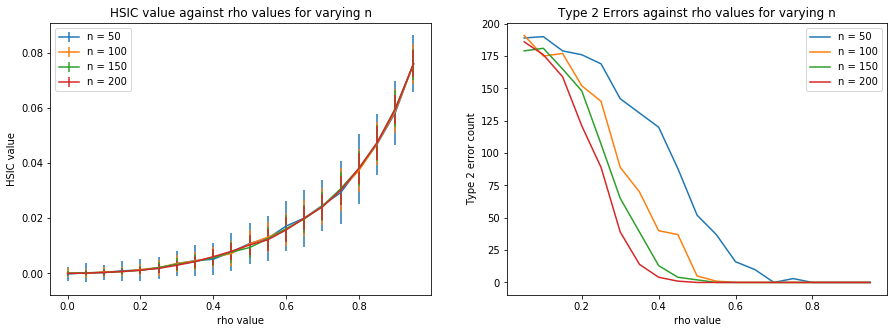

In [68]:
rho_vals=np.linspace(0,0.95,20)
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("HSIC value against rho values for varying n")
ax1.set_xlabel("rho value")
ax1.set_ylabel("HSIC value")
for i in np.arange(4):
    ax1.errorbar(rho_vals,HSIC_exp_1[i],yerr=HSIC_error_exp_1[i],label="n = " + str((i+1)*50))
ax1.legend()
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("Type 2 Errors against rho values for varying n")
ax2.set_xlabel("rho value")
ax2.set_ylabel("Type 2 error count")
for i in np.arange(4):
    ax2.plot(rho_vals[1:20],t2_exp_1[i],label="n = " + str((i+1)*50))
ax2.legend()

In [55]:
print(t1_exp_1)

[[8], [14], [10], [10]]


# Linear Functions with additive noise (rho zero and non-zero)

In [76]:
def linear_cond_independence_exp():
    
    HSIC_complete = []
    HSIC_complete_errors = []
    t1_complete = []
    t2_complete = []
    HSIC_all_vals = []
    HSIC_error = []
    t1_all_vals = []
    t2_all_vals = []
    rho_vals = []
    for n in [50,100,150,200]:
        print(n)
        HSIC_all_vals = []
        HSIC_mean = []
        HSIC_error = []
        t1_all_vals = []
        t2_all_vals = []
        for rho in np.linspace(0,0.98,20):
            print(rho)
            rho_vals.append(rho)
            HSIC_vals = []
            t_1 = 0
            t_2 = 0
            for i in np.arange(200):
                e_X,e_Y = multivariate_normal(mean=(0,0),cov=[[1,rho],[rho,1]],size=(n)).T
                e_Y = e_Y.reshape(e_Y.shape[0],1)
                e_X = e_X.reshape(e_X.shape[0],1)
                Z = np.random.normal(0,1,n)
                Z = Z.reshape(Z.shape[0],1)
                X = 5*Z + 0.001 + e_X
                Y = 4*Z + 0.002 + e_Y
                Y = Y.reshape(Y.shape[0],1)
                X = X.reshape(X.shape[0],1)
                data = np.concatenate((X,Y,Z),axis=1)
                p, residual_x, residual_y, HSIC = cond_indep(data,0,1,[2])
                if rho == 0:
                    if p < 0.05:
                        t_1 += 1
                if rho != 0:
                    if p >= 0.05:
                        t_2 += 1
                HSIC_vals.append(HSIC)
            HSIC_mean = np.mean(HSIC_vals)
            HSIC_error.append(np.std(HSIC_vals))
            HSIC_all_vals.append(HSIC_mean)
            if rho == 0:
                t1_all_vals.append(t_1)
            if rho != 0:
                t2_all_vals.append(t_2)
        HSIC_complete_errors.append(HSIC_error)
        HSIC_complete.append(HSIC_all_vals)
        t1_complete.append(t1_all_vals)
        t2_complete.append(t2_all_vals)
        
    return rho_vals, HSIC_complete_errors,HSIC_complete, t1_complete, t2_complete         

In [77]:
rho_vals_exp_2,HSIC_exp_2, HSIC_error_exp_2, t1_exp_2, t2_exp_2 = linear_cond_independence_exp()

50
0.0
0.05157894736842105
0.1031578947368421
0.15473684210526314
0.2063157894736842
0.25789473684210523
0.3094736842105263
0.36105263157894735
0.4126315789473684
0.46421052631578946
0.5157894736842105
0.5673684210526315
0.6189473684210526
0.6705263157894736
0.7221052631578947
0.7736842105263158
0.8252631578947368
0.8768421052631579
0.9284210526315789
0.98
100
0.0
0.05157894736842105
0.1031578947368421
0.15473684210526314
0.2063157894736842
0.25789473684210523
0.3094736842105263
0.36105263157894735
0.4126315789473684
0.46421052631578946
0.5157894736842105
0.5673684210526315
0.6189473684210526
0.6705263157894736
0.7221052631578947
0.7736842105263158
0.8252631578947368
0.8768421052631579
0.9284210526315789
0.98
150
0.0
0.05157894736842105
0.1031578947368421
0.15473684210526314
0.2063157894736842
0.25789473684210523
0.3094736842105263
0.36105263157894735
0.4126315789473684
0.46421052631578946
0.5157894736842105
0.5673684210526315
0.6189473684210526
0.6705263157894736
0.7221052631578947
0.

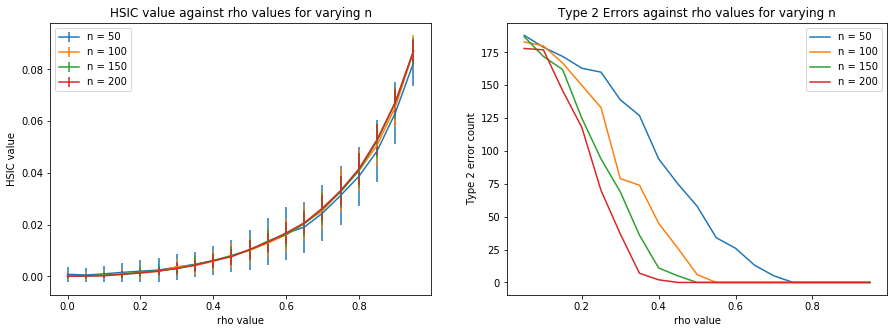

In [78]:
rho_vals=np.linspace(0,0.95,20)
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("HSIC value against rho values for varying n")
ax1.set_xlabel("rho value")
ax1.set_ylabel("HSIC value")
for i in np.arange(4):
    ax1.errorbar(rho_vals,HSIC_error_exp_2[i],yerr=HSIC_exp_2[i],label="n = " + str((i+1)*50))
ax1.legend()
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("Type 2 Errors against rho values for varying n")
ax2.set_xlabel("rho value")
ax2.set_ylabel("Type 2 error count")
for i in np.arange(4):
    ax2.plot(rho_vals[1:20],t2_exp_2[i],label="n = " + str((i+1)*50))
ax2.legend()

In [245]:
print(t1_exp_2)

[[18], [14], [14], [10]]


# Non-linear functions and additive noise testing conditional independence 

In [82]:
def nonlinear_cond_independence_exp():
    
    HSIC_complete = []
    HSIC_complete_errors = []
    t1_complete = []
    t2_complete = []
    HSIC_all_vals = []
    HSIC_error = []
    t1_all_vals = []
    t2_all_vals = []
    rho_vals = []
    for n in [50,100,150,200]:
        print(n)
        HSIC_all_vals = []
        HSIC_mean = []
        HSIC_error = []
        t1_all_vals = []
        t2_all_vals = []
        for rho in np.linspace(0,0.98,20):
            print(rho)
            rho_vals.append(rho)
            HSIC_vals = []
            t_1 = 0
            t_2 = 0
            for i in np.arange(200):
                e_X,e_Y = multivariate_normal(mean=(0,0),cov=[[1,rho],[rho,1]],size=(n)).T
                e_Y = e_Y.reshape(e_Y.shape[0],1)
                e_X = e_X.reshape(e_X.shape[0],1)
                Z = np.random.normal(0,1,n)
                Z = Z.reshape(Z.shape[0],1)
                X = (4*Z*Z) + 0.001 + e_X
                Y = np.sin(Z) + 0.002 + e_Y
                Y = Y.reshape(Y.shape[0],1)
                X = X.reshape(X.shape[0],1)
                data = np.concatenate((X,Y,Z),axis=1)
                p, residual_x, residual_y, HSIC = cond_indep(data,0,1,[2])
                if rho == 0:
                    if p < 0.05:
                        t_1 += 1
                if rho != 0:
                    if p >= 0.05:
                        t_2 += 1
                HSIC_vals.append(HSIC)
            HSIC_mean = np.mean(HSIC_vals)
            HSIC_error.append(np.std(HSIC_vals))
            HSIC_all_vals.append(HSIC_mean)
            if rho == 0:
                t1_all_vals.append(t_1)
            if rho != 0:
                t2_all_vals.append(t_2)
        HSIC_complete_errors.append(HSIC_error)
        HSIC_complete.append(HSIC_all_vals)
        t1_complete.append(t1_all_vals)
        t2_complete.append(t2_all_vals)
        
    return rho_vals, HSIC_complete, HSIC_complete_errors,t1_complete, t2_complete         

In [83]:
rho_vals_exp_3,HSIC_exp_3, HSIC_error_exp_3, t1_exp_3, t2_exp_3 = nonlinear_cond_independence_exp()

50
0.0
0.05157894736842105
0.1031578947368421
0.15473684210526314
0.2063157894736842
0.25789473684210523
0.3094736842105263
0.36105263157894735
0.4126315789473684
0.46421052631578946
0.5157894736842105
0.5673684210526315
0.6189473684210526
0.6705263157894736
0.7221052631578947
0.7736842105263158
0.8252631578947368
0.8768421052631579
0.9284210526315789
0.98
100
0.0
0.05157894736842105
0.1031578947368421
0.15473684210526314
0.2063157894736842
0.25789473684210523
0.3094736842105263
0.36105263157894735
0.4126315789473684
0.46421052631578946
0.5157894736842105
0.5673684210526315
0.6189473684210526
0.6705263157894736
0.7221052631578947
0.7736842105263158
0.8252631578947368
0.8768421052631579
0.9284210526315789
0.98
150
0.0
0.05157894736842105
0.1031578947368421
0.15473684210526314
0.2063157894736842
0.25789473684210523
0.3094736842105263
0.36105263157894735
0.4126315789473684
0.46421052631578946
0.5157894736842105
0.5673684210526315
0.6189473684210526
0.6705263157894736
0.7221052631578947
0.

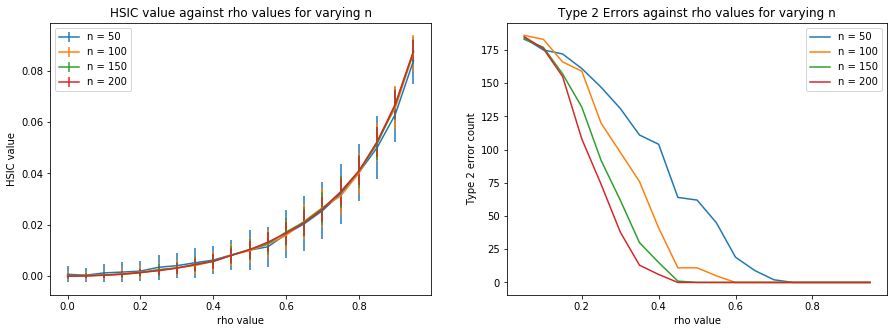

In [84]:
rho_vals=np.linspace(0,0.95,20)
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("HSIC value against rho values for varying n")
ax1.set_xlabel("rho value")
ax1.set_ylabel("HSIC value")
for i in np.arange(4):
    ax1.errorbar(rho_vals,HSIC_exp_3[i],yerr=HSIC_error_exp_3[i],label="n = " + str((i+1)*50))
ax1.legend()
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("Type 2 Errors against rho values for varying n")
ax2.set_xlabel("rho value")
ax2.set_ylabel("Type 2 error count")
for i in np.arange(4):
    ax2.plot(rho_vals[1:20],t2_exp_3[i],label="n = " + str((i+1)*50))
ax2.legend()

In [85]:
print(t1_exp_3)

[[22], [12], [9], [14]]


# Comparison of conditional independence with ensemble conditional independence

In [260]:
def ensemble_cond_independence_exp(alpha):
    

    rho_vals = []
    
    HSIC_all_vals_ens = []
    HSIC_mean_ens = []
    HSIC_error_ens = []
    t1_all_vals_ens = []
    t2_all_vals_ens = []
    
    HSIC_all_vals = []
    HSIC_mean = []
    HSIC_error = []
    t1_all_vals = []
    t2_all_vals = []
    for rho in np.linspace(0,0.98,10):
        print(rho)
        rho_vals.append(rho)
        HSIC_vals = []
        t_1 = 0
        t_2 = 0
        HSIC_vals_ens = []
        t_1_ens = 0
        t_2_ens = 0
        for i in np.arange(100):
            e_X,e_Y = multivariate_normal(mean=(0,0),cov=[[1,rho],[rho,1]],size=(100)).T
            e_Y = e_Y.reshape(e_Y.shape[0],1)
            e_X = e_X.reshape(e_X.shape[0],1)
            Z = np.random.normal(0,1,100)
            Z = Z.reshape(Z.shape[0],1)
            X = Z*np.cos(np.sin(8*Z*Z*Z))  + e_X
            Y = Z*Z*np.tanh(Z*Z + 7*Z*np.sin(2-Z)) + e_Y
            Y = Y.reshape(Y.shape[0],1)
            X = X.reshape(X.shape[0],1)
            data = np.concatenate((X,Y,Z),axis=1)
            p, residual_x, residual_y, HSIC = cond_indep(data,0,1,[2])
            p_ens, residual_x_ens,residual_y_ens, HSIC_ens = cond_indep_ensemble(data,0,1,[2])
            """
            print(np.mean(residual_x - residual_x_ens),np.std(residual_x - residual_x_ens))
            print(np.mean(residual_y - residual_y_ens),np.std(residual_y - residual_y_ens))
            """
            if rho == 0:
                if p < alpha:
                    t_1 += 1
                if p_ens < alpha:
                    t_1_ens += 1
            if rho != 0:
                if p >= alpha:
                    t_2 += 1
                if p_ens >= alpha:
                    t_2_ens += 1
            HSIC_vals.append(HSIC)
            HSIC_vals_ens.append(HSIC_ens)
        HSIC_mean = np.mean(HSIC_vals)
        HSIC_error.append(np.std(HSIC_vals))
        HSIC_all_vals.append(HSIC_mean)
        
        HSIC_mean_ens = np.mean(HSIC_vals_ens)
        HSIC_error_ens.append(np.std(HSIC_vals_ens))
        HSIC_all_vals_ens.append(HSIC_mean_ens)
        
        if rho == 0:
            t1_all_vals.append(t_1)
            t1_all_vals_ens.append(t_1_ens)
        if rho != 0:
            t2_all_vals.append(t_2)
            t2_all_vals_ens.append(t_2_ens)

    return rho_vals, HSIC_all_vals,HSIC_error, t1_all_vals, t2_all_vals, HSIC_all_vals_ens,HSIC_error_ens,t1_all_vals_ens, t2_all_vals_ens     

In [261]:
rho_vals_exp_4,HSIC_exp_4, HSIC_error_exp_4, t1_exp_4, t2_exp_4,HSIC_exp_5, HSIC_error_exp_5, t1_exp_5, t2_exp_5 = ensemble_cond_independence_exp(0.01)

0.0
0.10888888888888888
0.21777777777777776
0.32666666666666666
0.43555555555555553
0.5444444444444444
0.6533333333333333
0.7622222222222221
0.8711111111111111
0.98


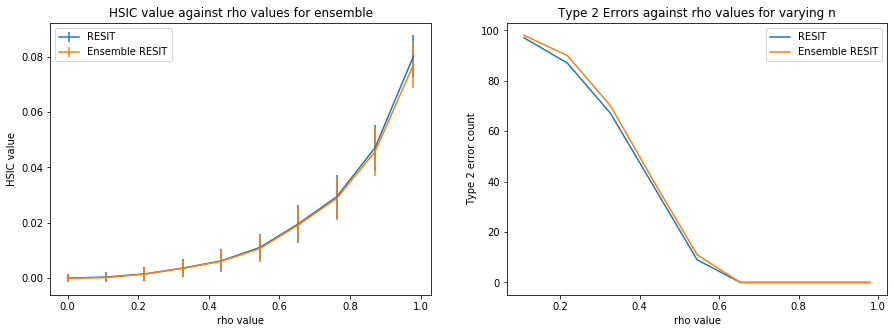

In [262]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("HSIC value against rho values for ensemble")
ax1.set_xlabel("rho value")
ax1.set_ylabel("HSIC value")
ax1.errorbar(rho_vals_exp_4,HSIC_exp_4,yerr=HSIC_error_exp_4,label="RESIT")
ax1.errorbar(rho_vals_exp_4,HSIC_exp_5,yerr=HSIC_error_exp_5,label="Ensemble RESIT")
ax1.legend()
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("Type 2 Errors against rho values for varying n")
ax2.set_xlabel("rho value")
ax2.set_ylabel("Type 2 error count")
ax2.plot(rho_vals_exp_4[1:10],t2_exp_4,label="RESIT")
ax2.plot(rho_vals_exp_4[1:10],t2_exp_5,label="Ensemble RESIT")
ax2.legend()

In [244]:
print(t1_exp_4,t1_exp_5)

[0] [0]


# PC Algorithm with 6 synthetic variables

0
()
0
()
0
()
0
()
0
()
0
()
0
()
0
()
0
()
0
()
0
(2,)
0
(3,)
0
(2,)
0
(1,)
0
(0,)


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


(None,
 [[set(), {2}, set(), set()],
  [{2}, set(), set(), set()],
  [set(), set(), set(), set()],
  [set(), set(), set(), set()]])

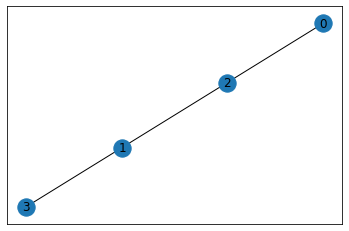

In [36]:
e_X,e_Y,e_W = multivariate_normal(mean=(0,0,0),cov=[[1,0,0],[0,1,0],[0,0,1]],size=(50)).T
e_Y = e_Y.reshape(e_Y.shape[0],1)
e_X = e_X.reshape(e_X.shape[0],1)
e_W = e_W.reshape(e_W.shape[0],1)
Z = np.random.normal(0,1,50)
Z = Z.reshape(Z.shape[0],1)
Y = np.random.normal(0,1,50)
Y = Y.reshape(Y.shape[0],1)
X = 5*Z + 3*Y + 0.001 + e_X
W = 6*Y + 2*Y + 0.003 + e_W
X = X.reshape(X.shape[0],1)
W = W.reshape(W.shape[0],1)
data = np.concatenate((W,X,Y,Z),axis=1)
estimate_skeleton(cond_indep,data,0.05)

0
()
0
()
0
()
0
()
0
()
0
()
0
()
0
()
0
()
0
()
0
()
0
()
0
(2,)
0
(3,)
0
(2,)
0
(3,)
0
(2,)
0
(1,)
1
(3,)
0
(0,)
1
(3,)
0
(0,)
1
(1,)
0
(2,)
0
(1,)
0
(1, 3)
0
(0, 3)
0
(0, 1)


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


(None,
 [[set(), {2}, set(), {2}],
  [{2}, set(), set(), set()],
  [set(), set(), set(), set()],
  [{2}, set(), set(), set()]])

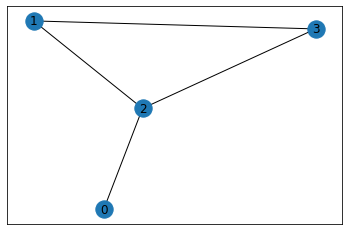

In [37]:
estimate_skeleton(cond_indep,features.iloc[:,4:8],0.05)

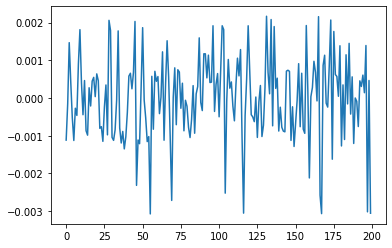

In [54]:
Z = np.random.normal(0,1,200)
Z = Z.reshape(Z.shape[0],1)
X = np.tanh(6*Z)*(Z**3)
GPR_1 = GaussianProcessRegressor()
GPR_1.fit(np.array(Z),np.array(X))
predictions_gpr_1 = GPR_1.predict(np.array(Z))
res_gpr_1 = predictions_gpr_1 - np.array(X)
plt.plot(res_gpr_1)

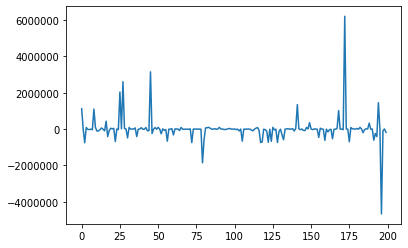

In [49]:
GAM_1 = GAM(n_splines=15).fit(np.array(Z),np.array(X))
predictions_gam_1 = GAM_1.predict(np.array(Z))
res_gam_1 = predictions_gam_1 - np.array(X).reshape(np.shape(X)[0])
plt.plot(res_gam_1)

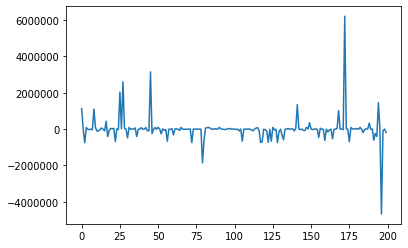

In [53]:
plt.plot(res_gpr_1 + res_gam_1.reshape(200,1))